In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import cohen_kappa_score

Load the data and the ground truths.

In [14]:
data = pd.read_csv('data/responses_binarized_long.csv')
gt_periodic = pd.read_csv('data/ground_truth_phrase_boundaries_periodic.csv')
gt_tracked = pd.read_csv('data/ground_truth_phrase_boundaries_tracked.csv')

In [15]:
data.head()

,exp_subject_id,scram_cond,stim_num,run,time,response
0,377777,8B,2,1,0,0
1,377777,8B,2,1,1,0
2,377777,8B,2,1,2,0
3,377777,8B,2,1,3,0
4,377777,8B,2,1,4,0


In [5]:
gt_periodic.head()

,scram_cond,stim_num,time,response
0,1B,1,0,0
1,1B,1,1,0
2,1B,1,2,0
3,1B,1,3,0
4,1B,1,4,0


In [16]:
subject_ids = data['exp_subject_id'].unique()

In [117]:
conditions = ['intact', '8B', '2B', '1B']
c = conditions[2]
stim_num = 2

# get the ground truth in array form
#this_gt = gt_periodic[gt_periodic['scram_cond']==c]
this_gt = gt_tracked[gt_tracked['scram_cond']==c]
this_gt = this_gt[this_gt['stim_num']==stim_num]
gt_array = this_gt['response'].to_numpy()

# get the data in matrix form
this_data = data[data['scram_cond']==c]
this_data = this_data[this_data['stim_num']==stim_num]
this_data = this_data[this_data['run']==2] # select only run 2
data_array = this_data['response'].to_numpy()
data_array = np.reshape(data_array, (subject_ids.shape[0], gt_array.shape[0]))

In [37]:
print(gt_array.shape)
print(data_array.shape)

(86,)
(43, 86)


In this form, the data are in a matrix of size `number of subjects x number of seconds`. We came back into python to do lagged "correlation" for each subject with the ground truth. (We're not using Pearson correlation, we're using Cohen's kappa).

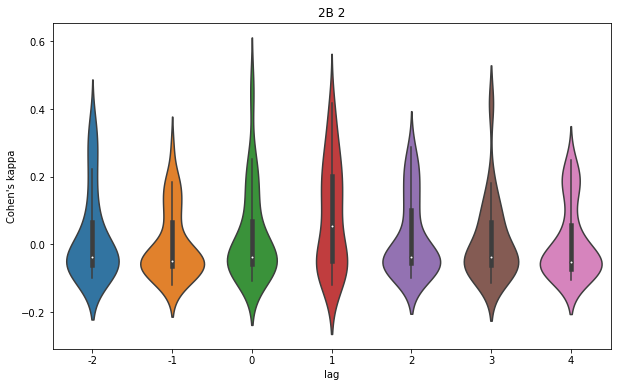

In [118]:
lags = range(-2,5)
kappa_values = np.zeros((subject_ids.shape[0],len(lags)))

for i in range(subject_ids.shape[0]):
#for i in range(1):
    this_sub = data_array[i,:]
    
    for l in range(len(lags)):
        lag = lags[l]
    
        if lag > 0:
            this_sub_crop = this_sub[lag:]
            this_gt = gt_array[:-lag]
            
        elif lag < 0:
            this_sub_crop = this_sub[:lag]
            this_gt = gt_array[-lag:]
        
        elif lag == 0:
            this_sub_crop = this_sub
            this_gt = gt_array
            
        kappa_values[i,l] = cohen_kappa_score(this_sub_crop,this_gt)

fig, ax = plt.subplots(figsize=(10,6))
sns.violinplot(data = kappa_values)
ax.set_xticklabels(lags)
ax.set_xlabel('lag')
ax.set_ylabel("Cohen's kappa")
ax.set_title('%s %d'%(c, stim_num))
#plt.savefig('plots/%s_%d_lag_kappa.png'%(c,stim_num),dpi=300);
#plt.savefig('plots/%s_%d_lag_kappa_periodic.png'%(c,stim_num),dpi=300);
plt.savefig('plots/%s_%d_lag_kappa_tracked.png'%(c,stim_num),dpi=300);

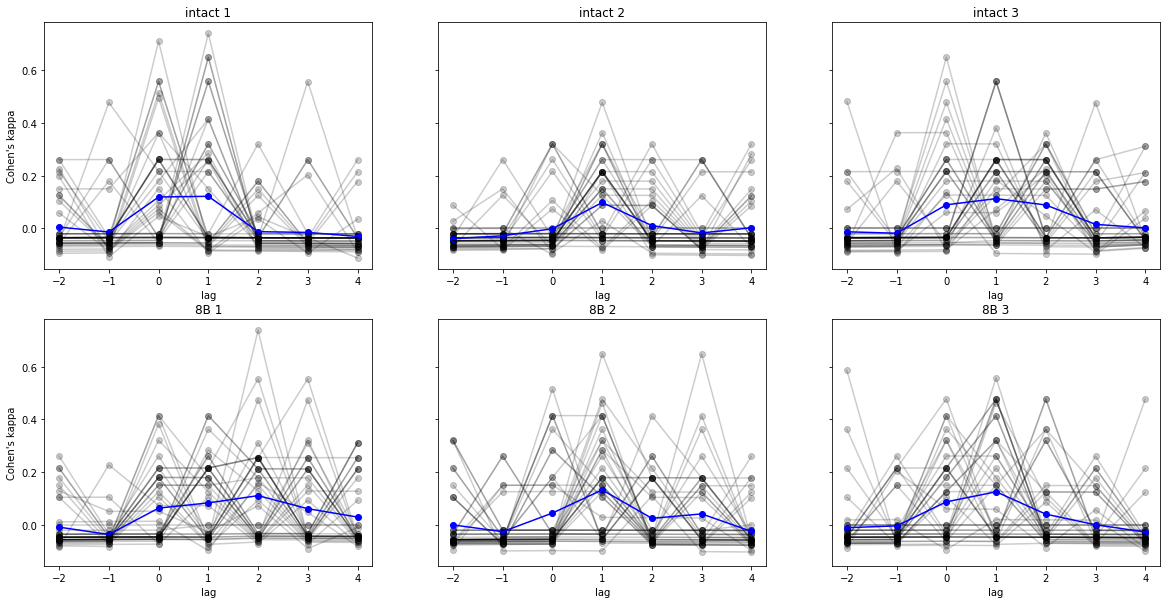

In [50]:
# big loop to show all on one plot

conditions = ['intact', '8B']
#conditions = ['2B', '1B'] 
num_stim = 3 # 3 stimuli for each condition

lags = range(-2,5)

# create the figure here
fig, ax = plt.subplots(2, 3, figsize=(20,10), sharey=True)
ax[0,0].set_ylabel("Cohen's kappa")
ax[1,0].set_ylabel("Cohen's kappa")
#fig.tight_layout()

for cond in range(len(conditions)):
    c = conditions[cond]
    
    for n in range(num_stim):
        stim_num = n + 1

        # get the ground truth in array form
        this_gt = gt_periodic[gt_periodic['scram_cond']==c]
        #this_gt = gt_tracked[gt_tracked['scram_cond']==c]
        this_gt = this_gt[this_gt['stim_num']==stim_num]
        gt_array = this_gt['response'].to_numpy()

        # get the data in matrix form
        this_data = data[data['scram_cond']==c]
        this_data = this_data[this_data['stim_num']==stim_num]
        this_data = this_data[this_data['run']==2] # select only run 2
        data_array = this_data['response'].to_numpy()
        data_array = np.reshape(data_array, (subject_ids.shape[0], gt_array.shape[0]))
        
        kappa_values = np.zeros((subject_ids.shape[0],len(lags)))

        for i in range(subject_ids.shape[0]):
            this_sub = data_array[i,:]
    
            for l in range(len(lags)):
                lag = lags[l]
    
                if lag > 0:
                    this_sub_crop = this_sub[lag:]
                    this_gt = gt_array[:-lag]
            
                elif lag < 0:
                    this_sub_crop = this_sub[:lag]
                    this_gt = gt_array[-lag:]
        
                elif lag == 0:
                    this_sub_crop = this_sub
                    this_gt = gt_array
            
                kappa_values[i,l] = cohen_kappa_score(this_sub_crop,this_gt)

                
        #sns.violinplot(data = kappa_values, ax = ax[cond,n])
        for s in range(subject_ids.shape[0]):
            ax[cond,n].plot(lags, kappa_values[s,:], color='black', alpha=0.2)
            ax[cond,n].scatter(lags, kappa_values[s,:], color='black', alpha=0.2)
            
        ax[cond,n].plot(lags, np.mean(kappa_values,axis=0), color='blue')
        ax[cond,n].scatter(lags, np.mean(kappa_values,axis=0), color='blue')
        
        #ax[cond,n].set_xticklabels(lags)
        ax[cond,n].set_xlabel('lag')
        ax[cond,n].set_title('%s %d'%(c, stim_num))

#plt.savefig('plots/more_scrambled_all_lag_kappa_traces_periodic.png',dpi=500);       
plt.savefig('plots/less_scrambled_all_lag_kappa_traces.png',dpi=500);

Instead of plotting here, save the values for analysis in R:

In [52]:
def calculate_kappa(output_array, gt_type, conditions, num_stim=3, num_runs=2, lags=range(-2,5)):
    
    for c in range(len(conditions)):
        cond = conditions[c]
    
        for n in range(num_stim):
            stim_num = n + 1

            # get the ground truth in array form
            if gt_type == 'periodic': this_gt = gt_periodic[gt_periodic['scram_cond']==cond]
            elif gt_type == 'tracked': this_gt = gt_tracked[gt_tracked['scram_cond']==cond]
            this_gt = this_gt[this_gt['stim_num']==stim_num]
            gt_array = this_gt['response'].to_numpy()

            for r in range(num_runs):

                # get the data in matrix form
                this_data = data[data['scram_cond']==cond]
                this_data = this_data[this_data['stim_num']==stim_num]
                this_data = this_data[this_data['run']==r+1]
                data_array = this_data['response'].to_numpy()
                data_array = np.reshape(data_array, (subject_ids.shape[0], gt_array.shape[0]))

                for i in range(subject_ids.shape[0]):
                    this_sub = data_array[i,:]
    
                    for l in range(len(lags)):
                        lag = lags[l]
    
                        if lag > 0:
                            this_sub_crop = this_sub[lag:]
                            this_gt = gt_array[:-lag]
            
                        elif lag < 0:
                            this_sub_crop = this_sub[:lag]
                            this_gt = gt_array[-lag:]
        
                        elif lag == 0:
                            this_sub_crop = this_sub
                            this_gt = gt_array
            
                        output_array[c,n,r,i,l] = cohen_kappa_score(this_sub_crop,this_gt)
    
    return

In [53]:
num_conds = 2 # sets of two: more scrambled and less scrambled
num_stim = 3
num_runs = 2
lags = lags = range(-2,5)

kappa_values_actual_gt = np.zeros((num_conds, num_stim, num_runs, subject_ids.shape[0],len(lags)))
calculate_kappa(kappa_values_actual_gt,'periodic',['intact', '8B'])

kappa_values_periodic = np.zeros((num_conds, num_stim, num_runs, subject_ids.shape[0],len(lags)))
calculate_kappa(kappa_values_periodic,'periodic',['2B', '1B'])

kappa_values_tracked = np.zeros((num_conds, num_stim, num_runs, subject_ids.shape[0],len(lags)))
calculate_kappa(kappa_values_tracked,'tracked',['2B', '1B'])

In [55]:
print(kappa_values_tracked.shape)

(2, 3, 2, 43, 7)


In [83]:
# create dataframe to save as csv
less_scrambled_conds = ['intact','8B']
more_scrambled_conds = ['2B','1B']

all_kappa = pd.DataFrame()

for c in range(num_conds):
    for s in range(num_stim):
        for r in range(num_runs):
          
            this_df_actual = pd.DataFrame(data=kappa_values_actual_gt[c,s,r,:,:],columns=lags)
            this_df_actual.insert(0, 'gt_type', 'actual')
            this_df_actual.insert(1, 'scram_cond', less_scrambled_conds[c])
            this_df_actual.insert(2, 'stim_num', s+1)
            this_df_actual.insert(3, 'run', r+1)

            this_df_actual = pd.melt(this_df_actual, 
                                     id_vars=['gt_type','scram_cond','stim_num','run'],
                                     var_name='lag',
                                     value_name='kappa')

            this_df_periodic = pd.DataFrame(data=kappa_values_periodic[c,s,r,:,:],columns=lags)
            this_df_periodic.insert(0, 'gt_type', 'periodic')
            this_df_periodic.insert(1, 'scram_cond', more_scrambled_conds[c])
            this_df_periodic.insert(2, 'stim_num', s+1)
            this_df_periodic.insert(3, 'run', r+1)

            this_df_periodic = pd.melt(this_df_periodic,
                                       id_vars=['gt_type','scram_cond','stim_num','run'],
                                       var_name='lag',
                                       value_name='kappa')

            this_df_tracked = pd.DataFrame(data=kappa_values_tracked[c,s,r,:,:],columns=lags) 
            this_df_tracked.insert(0, 'gt_type', 'tracked')
            this_df_tracked.insert(1, 'scram_cond', more_scrambled_conds[c])
            this_df_tracked.insert(2, 'stim_num', s+1)
            this_df_tracked.insert(3, 'run', r+1)

            this_df_tracked = pd.melt(this_df_tracked,
                                      id_vars=['gt_type','scram_cond','stim_num','run'],
                                      var_name='lag',
                                      value_name='kappa')

            all_kappa = all_kappa.append([this_df_actual,this_df_periodic,this_df_tracked])

In [84]:
all_kappa

,gt_type,scram_cond,stim_num,run,lag,kappa
0,actual,intact,1,1,-2,-0.020243
1,actual,intact,1,1,-2,-0.046729
2,actual,intact,1,1,-2,-0.082873
3,actual,intact,1,1,-2,-0.046729
4,actual,intact,1,1,-2,-0.055866
...,...,...,...,...,...,...
296,tracked,1B,3,2,4,-0.053283
297,tracked,1B,3,2,4,-0.021352
298,tracked,1B,3,2,4,-0.062176
299,tracked,1B,3,2,4,0.182336


In [85]:
all_kappa.to_csv('data/lag_kappa_values.csv',index=False)